Kaggle challenge: [Grupo Bimbo Inventory Demand](https://www.kaggle.com/c/grupo-bimbo-inventory-demand/data)

In [1]:
import numpy as np
import pandas as pd
from zipfile import ZipFile

zip_file = ZipFile('S:\Kaggles\#Data\grupo-bimbo-inventory-demand.zip')
dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename), nrows=200000)
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv')}

In [2]:
dfs.keys()

dict_keys(['cliente_tabla.csv', 'sample_submission.csv', 'test.csv', 'train.csv', 'town_state.csv', 'producto_tabla.csv'])

Let's load and summarize weeks one by one, and produce relative distributions. The general idea is to catch fractal patterns of a week

UPD: Can't load even single week to summarize it. Change approach.

According to [this kernel from Kaggle](https://www.kaggle.com/anokas/exploratory-data-analysis) if we simply calculate and output the most common target value from the dataset, we can score 0.82735 RMSLE. Let's see if we can have more individual approach

Try: load chunks and group by Sales Depot ID (Agencia_ID) and Product ID (Producto_ID) and, for example, aggregate stats and compose into weekly stats by Depot or Product (since some products/depots might have outstandingly high return rate compared to target mode)

In [3]:
dfs['train.csv'].tail()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
199995,3,1116,1,1466,2309869,1238,8,78.64,0,0.0,8
199996,3,1116,1,1466,2309869,1240,8,67.04,0,0.0,8
199997,3,1116,1,1466,2309869,1242,6,45.84,0,0.0,6
199998,3,1116,1,1466,2309869,1250,27,206.28,0,0.0,27
199999,3,1116,1,1466,2309869,1278,13,58.50,0,0.0,13


In [4]:
train_1_Agencia = dfs['train.csv'].groupby('Agencia_ID')['Demanda_uni_equil'].mean()

In [5]:
train_1_Agencia

Agencia_ID
1110    14.967682
1111     5.968699
1112     5.282621
1113     7.128844
1114    66.457816
1116     6.268541
Name: Demanda_uni_equil, dtype: float64

Certainly some depots experience substantially higher demands (lower order return rate/higher sales)

In [6]:
train_1_Producto = dfs['train.csv'].groupby('Producto_ID')['Demanda_uni_equil'].mean()

In [7]:
train_1_Producto

Producto_ID
72         5.669711
73         2.240000
108      109.333333
141        6.200000
145       17.877551
            ...    
49860     15.833333
49986      3.090909
49988     19.277778
49990      4.500000
49994      2.444444
Name: Demanda_uni_equil, Length: 478, dtype: float64

Same inequality is true for the products

In [8]:
train_1_Producto_Agencia = dfs['train.csv'].groupby(['Producto_ID', 'Agencia_ID'])['Demanda_uni_equil'].mean()

In [9]:
train_1_Producto_Agencia

Producto_ID  Agencia_ID
72           1111           5.359375
             1112           4.481081
             1113           7.055556
73           1110           9.000000
             1111           2.352321
                             ...    
49990        1111           0.000000
             1112           3.000000
             1113          12.000000
49994        1111           2.714286
             1112           1.500000
Name: Demanda_uni_equil, Length: 957, dtype: float64

Bascialy same product can experince vastly different demands in depending on a depot.

Now, lets upload several chunks of data to see if there's much variance thoughout several weeks.

UPD: Let's upload tail chunk first for shallow check

In [10]:
dfs_tail = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename), nrows=200000)
       for text_file in zip_file.infolist()
            
       if text_file.filename.endswith('.csv')}

Keep in mind info from [this comment](https://www.kaggle.com/anokas/exploratory-data-analysis#123109) from Kaggle:

TODO:

Make a heatmap agencia-producto and mean demand, for each week, and try to use the same value scale for color coding
 
Also to get idea of range - compute full summary of target for agencia-product-week triads
 
Also check how important the outliers in sales/demand are (i.e. how much money they make to justify serving them)

Let's import Dask to get all the data into dataframe and compute week-product-agency statistics (via describe() )

In [11]:
import dask.dataframe as dd

In [12]:
#zip_file = ZipFile('S:\Kaggles\#Data\grupo-bimbo-inventory-demand.zip')
#dfs_dask = pd.read_csv(zip_file.open('train.csv'), nrows=200000)
#dfs_dask = dd.read_csv('S:\Kaggles\#Data\grupo-bimbo-inventory-demand.gz', compression='gzip')
#either compress file to parquet or decompress and parse as is
#train_full = dd.read_csv('S:\Kaggles\#Data\train.csv')
FULL_train= dd.read_csv('../#Data/train.csv')

In [13]:
FULL_train_Agencia = FULL_train.groupby(['Agencia_ID'])['Demanda_uni_equil'].mean()
FULL_train_Producto = FULL_train.groupby(['Producto_ID'])['Demanda_uni_equil'].mean()
FULL_train_Producto_Agencia = FULL_train.groupby(['Producto_ID', 'Agencia_ID'])['Demanda_uni_equil'].mean()

In [14]:
FULL_train_Agencia.head(5)

Agencia_ID
1110    15.821312
1111     6.013929
1112     5.473072
1113     7.023729
1114    70.038228
Name: Demanda_uni_equil, dtype: float64

In [15]:
FULL_train_Producto.head(5)

Producto_ID
72      4.896193
73      3.193657
100     8.814516
108    73.500000
123    10.941723
Name: Demanda_uni_equil, dtype: float64

In [16]:
FULL_train_Semana = FULL_train.groupby(['Semana'])['Demanda_uni_equil'].mean()

In [17]:
FULL_train_Semana.head(20)

C:\Users\Alexey\Anaconda3\lib\site-packages\dask\dataframe\core.py:5738: UserWarning: Insufficient elements for `head`. 20 elements requested, only 7 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


Semana
3    6.955922
4    7.231772
5    7.311138
6    7.246106
7    7.377264
8    7.257237
9    7.210733
Name: Demanda_uni_equil, dtype: float64

As we can see, the total mean demand is relatively the same throughout the weeks

In [18]:
FULL_train_Semana.describe().compute()

count    7.000000
mean     7.227167
std      0.132104
min      6.955922
25%      7.221252
50%      7.246106
75%      7.284188
max      7.377264
Name: Demanda_uni_equil, dtype: float64

Thus we can use mean or median values on depots and products from the whole dataset, and it'll be relatively representative

Now let's build a heatmap for depots-products-demand

In [19]:
FULL_train['Demanda_uni_equil'].describe().compute()

count    7.418046e+07
mean     7.224564e+00
std      2.177119e+01
min      0.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      8.000000e+00
max      5.000000e+03
Name: Demanda_uni_equil, dtype: float64

(So std = 3x mean; lol)

In [20]:
#Calc the total number of depots
FULL_train['Agencia_ID'].unique().count().compute()

552

In [21]:
AGG_train_Producto_Agencia = FULL_train_Producto_Agencia.compute()
AGG_train_Agencia = FULL_train_Agencia.compute()
AGG_train_Producto = FULL_train_Producto.compute()

#FULL_train_pivot = FULL_train.groupby('Agencia_ID')[['Producto_ID', 'Demanda_uni_equil']]
#FULL_train_pivot['Producto_ID'] = FULL_train_pivot['Producto_ID'].astype('category')
#FULL_train_pivot['Producto_ID'] = FULL_train_pivot['Producto_ID'].cat.as_known()
#FULL_train_pivot = FULL_train.pivot_table(index='Agencia_ID', columns='Producto_ID', values='Demanda_uni_equil')
#hmap = sns.heatmap(data=FULL_train_Producto_Agencia)

#AGG_train_Agencia

,Producto_ID,Agencia_ID,Demanda_uni_equil
47112,36442,2059,4141.00
688,1167,1160,3612.00
70186,36988,2030,3438.50
68517,31319,1535,3413.25
45394,31669,2059,3400.00
...,...,...,...
58613,36005,3212,0.00
58612,36005,3211,0.00
58610,36005,2644,0.00
58609,36005,2263,0.00


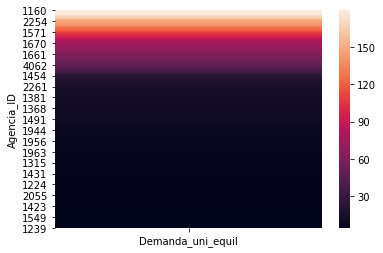

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


DF_train_Agencia = pd.DataFrame(AGG_train_Agencia) #.reset_index()


#AGG_train_pivot = AGG_train_pivot.pivot("Producto_ID", "Agencia_ID", "Demanda_uni_equil")
#AGG_train_Agencia = AGG_train_Agencia.pivot("Semana", "Agencia_ID", "Demanda_uni_equil")
#hmap = sns.heatmap(data=FULL_train_pivot)
#sns.barplot(y=DF_train_Agencia.index, x=DF_train_Agencia['Demanda_uni_equil'])
#hmap = sns.heatmap(data=AGG_train_pivot)

DF_train_Agencia.sort_values(by='Demanda_uni_equil', ascending=False, inplace=True)
#DF_train_Agencia['Demanda_uni_equil'] = np.log(DF_train_Agencia['Demanda_uni_equil'])


hmap = sns.heatmap(data=DF_train_Agencia, robust=True)


#DF_train_Agencia.describe()

AGG_train_pivot = AGG_train_Producto_Agencia.reset_index()
AGG_train_pivot.sort_values(by='Demanda_uni_equil', ascending=False, inplace=True)
#AGG_train_pivot = AGG_train_pivot.pivot_table(index="Producto_ID", columns="Agencia_ID", values="Demanda_uni_equil", dropna=True)
AGG_train_pivot

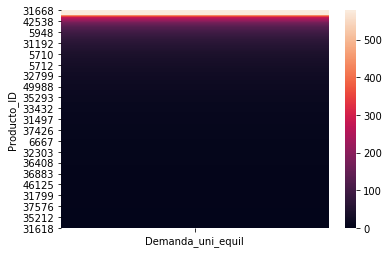

In [23]:
DF_train_Producto = pd.DataFrame(AGG_train_Producto) #.reset_index()
DF_train_Producto.sort_values(by='Demanda_uni_equil', ascending=False, inplace=True)
DF_train_Producto


hmap = sns.heatmap(data=DF_train_Producto, robust=True)

There are clearly some top performers among the products. Log transform here doesn't help much. What if we separate products into 2 categories and calculate the relative amount of money they make. Also do the same for different depots.

Try: cut out low percentiles and look at the distributions; then use k-means to produce meaningful categories of products/depots based on demands they experence; then engineer labels for them and use those labels or their encoding to predict the demand.

Think about: how can we estimate how well certain products do in certain depots (maybe just relatively). Maybe consider relative demand in a product in specific depot + absolute demand in a product. 

Maybe produce for each depot and each product: 
-relative local demand,
-relative global demand, 
-absolute local demand,
-absolute global demand

The idea behind local demands is to account for products which are very popular only in some places. Such products may or may not become popular globally, but we'd still like to supply the local demand regardless. Also, if they might become popular, they won't necessarily become popular immediately. For example, if we test some localy popular product in a new depot, it might take some time to decide wether the product is popular in the new place.

For now let's use 4 quartiles for labeling

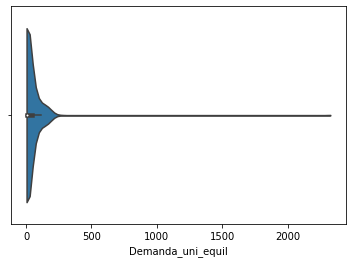

In [24]:
DF_train_Agencia.describe()
#plt.figure(figsize=(14,7))
sns.violinplot(x='Demanda_uni_equil', data=DF_train_Agencia, inner="box", scale="width", cut=0)

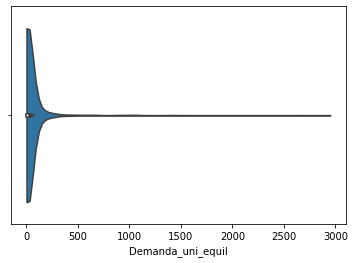

In [25]:
DF_train_Producto.describe()
#plt.figure(figsize=(14,7))
sns.violinplot(x='Demanda_uni_equil', data=DF_train_Producto.dropna(), inner="box", scale="width", cut=0)

Cut the top performer outliers and do normal(first, recalt those two dataframes coz they were spoiled by transform)

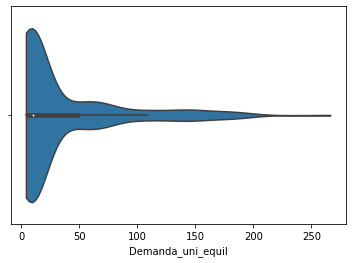

In [26]:
DF_train_Agencia_chill = DF_train_Agencia.drop(1160)
sns.violinplot(x='Demanda_uni_equil', data=DF_train_Agencia_chill, inner="box", scale="count", cut=0)

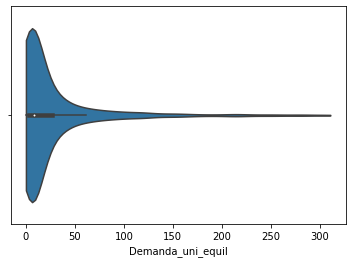

In [27]:
DF_train_Producto.head(30)
top = float(DF_train_Producto.quantile(q=0.97))
DF_train_Producto_chill = DF_train_Producto[DF_train_Producto['Demanda_uni_equil'] < top]
sns.violinplot(x='Demanda_uni_equil', data=DF_train_Producto_chill, inner="box", scale="count", cut=0)

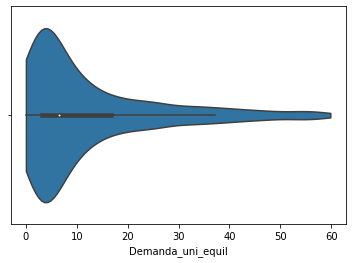

In [28]:
pre_top = float(DF_train_Producto.quantile(q=0.85))
DF_train_Producto_chill_chill = DF_train_Producto[DF_train_Producto['Demanda_uni_equil'] < pre_top]
sns.violinplot(x='Demanda_uni_equil', data=DF_train_Producto_chill_chill, inner="box", scale="count", cut=0)

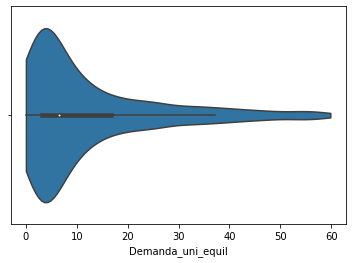

In [29]:
pre_bot = float(DF_train_Producto.quantile(q=0.85))
DF_train_Producto_freeze = DF_train_Producto[DF_train_Producto['Demanda_uni_equil'] < pre_bot]
sns.violinplot(x='Demanda_uni_equil', data=DF_train_Producto_freeze, inner="box", scale="count", cut=0)

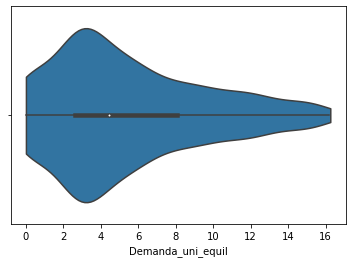

In [30]:
bot = float(DF_train_Producto.quantile(q=0.63))
DF_train_Producto_freeze_freeze = DF_train_Producto[DF_train_Producto['Demanda_uni_equil'] < bot]
sns.violinplot(x='Demanda_uni_equil', data=DF_train_Producto_freeze_freeze, inner="box", scale="count", cut=0)

draw distributions based on counts and reevaluate those quantiles (and then use k-means coz then you'll see how many labels you roughly have)

Or better engineer fresh features aready, but first - find the sum of revenue for all those categries

In [31]:
FULL_sum = FULL_train.groupby(['Producto_ID']) #[['Venta_uni_hoy', 'Venta_hoy']]

In [32]:
FULL_sum_Producto = FULL_sum['Venta_hoy'].sum().compute()

In [33]:
top_3_percent = DF_train_Producto[DF_train_Producto['Demanda_uni_equil'] >= top].index.values.tolist() 

In [34]:
type(FULL_sum_Producto)

pandas.core.series.Series

In [35]:
top_3_sum_Producto = FULL_sum_Producto[FULL_sum_Producto.index.isin(top_3_percent)]

In [36]:
top_3_sum_Producto.sum() / FULL_sum_Producto.sum()

0.006381740164615298

In [37]:
top_37_percent = DF_train_Producto[DF_train_Producto['Demanda_uni_equil'] >= bot].index.values.tolist() 

In [38]:
top_37_sum_Producto = FULL_sum_Producto[FULL_sum_Producto.index.isin(top_37_percent)]
top_37_sum_Producto.sum() / FULL_sum_Producto.sum()

0.2684110903757708

So top 37% of products by demand value (the long tail) provides only 27% of revenue. 


Now good thing would be to check to partition depots by experienced demand; then engineer the new numeric features, then make and score random forest model, AND ONLY AFTER THAT consider any kind of binning to accomodate some linear model.

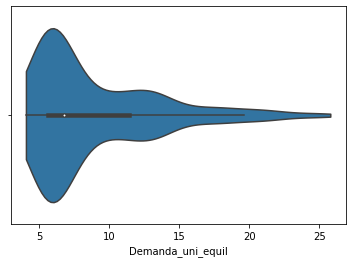

In [39]:
top1 = float(DF_train_Agencia.quantile(q=0.99))
top2 = float(DF_train_Agencia.quantile(q=0.90))
top3 = float(DF_train_Agencia.quantile(q=0.71))
#top4 = float(DF_train_Agencia.quantile(q=0.97))
DF_train_Agencia_refrigerator = DF_train_Agencia[DF_train_Agencia['Demanda_uni_equil'] < top3]
sns.violinplot(x='Demanda_uni_equil', data=DF_train_Agencia_refrigerator, inner="box", scale="count", cut=0)

Note: You have to figure out how to cut the plot properly so the shape of the distribution remains ffs

In [40]:
FULL_sum_Agencia = FULL_train.groupby(['Agencia_ID'])
FULL_sum_Agencia = FULL_sum_Agencia['Venta_hoy'].sum().compute()

In [41]:
top_X_percent = DF_train_Agencia[DF_train_Agencia['Demanda_uni_equil'] >= top3].index.values.tolist() 
top_X_sum_Agencia = FULL_sum_Agencia[FULL_sum_Agencia.index.isin(top_X_percent)]

In [42]:
top_X_sum_Agencia.sum() / FULL_sum_Agencia.sum()

0.22583956473001524

So top 29% of depots by demand value (the long tail) provides only 22% of revenue. 

It turns out those outliers are not that heavy

Now, figure out a smart way to compose and join those 4 new numeric (relative/absolute) features to the train set 

But before that, since there's not much features available in the test set - what if you take mean demand for each product for each depot and use just that for random forest regressor? << shitty idea, new plan ahead

In [43]:
FULL_train_Producto_Agencia.head()

Producto_ID  Agencia_ID
72           1111          5.520701
             1112          4.270435
             1113          6.926998
             1116          6.028628
             1117          4.433088
Name: Demanda_uni_equil, dtype: float64

In [44]:
READY_FULL_train_Producto_Agencia = FULL_train_Producto_Agencia.reset_index()
READY_FULL_train_Producto_Agencia.head()

,Producto_ID,Agencia_ID,Demanda_uni_equil
0,72,1111,5.520701
1,72,1112,4.270435
2,72,1113,6.926998
3,72,1116,6.028628
4,72,1117,4.433088


In [45]:
'''
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=100, max_depth=2, random_state=0, n_jobs=-1)
'''

'\nfrom sklearn.ensemble import RandomForestRegressor\nforest = RandomForestRegressor(n_estimators=100, max_depth=2, random_state=0, n_jobs=-1)\n'

In [46]:
'''
X = READY_FULL_train_Producto_Agencia.drop('Demanda_uni_equil', axis=1)
y = READY_FULL_train_Producto_Agencia['Demanda_uni_equil']
'''

"\nX = READY_FULL_train_Producto_Agencia.drop('Demanda_uni_equil', axis=1)\ny = READY_FULL_train_Producto_Agencia['Demanda_uni_equil']\n"

In [47]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)

In [48]:
'''X_train = X.iloc[0:10000000]
'''

'X_train = X.iloc[0:10000000]\n'

In [49]:
'''forest.fit(X_train)
'''


'forest.fit(X_train)\n'

And what if you use 2 stacked models from light dataframes of means of each thing?

Let's do stacking right now:

In [50]:
'''
forest_Agencia = RandomForestRegressor(n_estimators=100, max_depth=2, random_state=0, n_jobs=-1)
forest_Producto = RandomForestRegressor(n_estimators=100, max_depth=2, random_state=0, n_jobs=-1)
'''

'\nforest_Agencia = RandomForestRegressor(n_estimators=100, max_depth=2, random_state=0, n_jobs=-1)\nforest_Producto = RandomForestRegressor(n_estimators=100, max_depth=2, random_state=0, n_jobs=-1)\n'

In [51]:
'''
DF_train_Agencia.reset_index(inplace=True)
#X = DF_train_Agencia.drop('Demanda_uni_equil', axis=1).to_numpy()
X = DF_train_Agencia['Agencia_ID'].to_numpy()
y = DF_train_Agencia['Demanda_uni_equil'].to_numpy()

'''

"\nDF_train_Agencia.reset_index(inplace=True)\n#X = DF_train_Agencia.drop('Demanda_uni_equil', axis=1).to_numpy()\nX = DF_train_Agencia['Agencia_ID'].to_numpy()\ny = DF_train_Agencia['Demanda_uni_equil'].to_numpy()\n\n"

In [52]:
#X.reset_index()
#X
#DF_train_Agencia

In [53]:
'''X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)
forest_Agencia.fit(X_train.reshape(-1, 1), y_train)
forest_Agencia.score(X_test.reshape(-1, 1), y_test)

#DF_train_Producto
'''

'X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)\nforest_Agencia.fit(X_train.reshape(-1, 1), y_train)\nforest_Agencia.score(X_test.reshape(-1, 1), y_test)\n\n#DF_train_Producto\n'

In [54]:
'''
DF_train_Producto.reset_index(inplace=True)
#X = DF_train_Agencia.drop('Demanda_uni_equil', axis=1).to_numpy()
X = DF_train_Producto['Producto_ID'].to_numpy()
y = DF_train_Producto['Demanda_uni_equil'].to_numpy()
'''

"\nDF_train_Producto.reset_index(inplace=True)\n#X = DF_train_Agencia.drop('Demanda_uni_equil', axis=1).to_numpy()\nX = DF_train_Producto['Producto_ID'].to_numpy()\ny = DF_train_Producto['Demanda_uni_equil'].to_numpy()\n"

In [55]:
'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)
forest_Producto.fit(X_train.reshape(-1, 1), y_train)
forest_Producto.score(X_test.reshape(-1, 1), y_test)
'''

'\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)\nforest_Producto.fit(X_train.reshape(-1, 1), y_train)\nforest_Producto.score(X_test.reshape(-1, 1), y_test)\n'

In [56]:
#sns.distplot(y_test)

In [57]:
#sns.distplot(forest_Producto.predict(X_test.reshape(-1, 1)))

In [58]:
FULL_train_Semana = FULL_train.groupby(['Semana'])

In [59]:
#Semana_1 = FULL_train_Semana.loc['3']
FULL_train_Semana['Demanda_uni_equil'].mean().compute()

Semana
3    6.955922
4    7.231772
5    7.311138
6    7.246106
7    7.377264
8    7.257237
9    7.210733
Name: Demanda_uni_equil, dtype: float64

In [60]:
FULL_Semana_3 = FULL_train[FULL_train['Semana'] == 3]
FULL_Semana_4 = FULL_train[FULL_train['Semana'] == 4]
FULL_Semana_5 = FULL_train[FULL_train['Semana'] == 5]
FULL_Semana_6 = FULL_train[FULL_train['Semana'] == 6]
FULL_Semana_7 = FULL_train[FULL_train['Semana'] == 7]
FULL_Semana_8 = FULL_train[FULL_train['Semana'] == 8]
FULL_Semana_9 = FULL_train[FULL_train['Semana'] == 9]

In [61]:
#FULL_Semana_3.head()

In [62]:
#FULL_Semana_3[FULL_Semana_3['Producto_ID'] == 1212].head()

So demand is aclculated for each client. But we can aggregate it by product and depot and it'd make sense still; Also, it makes sense to add mean demand for each client(maybe even by product)

In [63]:
len(FULL_Semana_4)

11009593

When we gonna make a linear model out of this, check out [transformers for our very skewed distributions](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_map_data_to_normal.html)

In [64]:
# A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
# https://www.kaggle.com/marknagelberg/caterpillar-tube-pricing/rmsle-function
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

Fuck it, i'll use even more simple solution without ML, which will be scalable, just with aditional features

In [65]:
X_train_Semana_4 = FULL_Semana_4[['Agencia_ID', 'Cliente_ID', 'Producto_ID']]
#y_train_Semana_4 = FULL_Semana_4['Demanda_uni_equil']

In [113]:
X_train_Semana_4 = FULL_Semana_4.drop(columns=['Semana', 'Canal_ID', 'Ruta_SAK',
                                               'Venta_uni_hoy', 'Venta_hoy',
                                               'Dev_uni_proxima', 'Dev_proxima',
                                               'Demanda_uni_equil'])

In [114]:
X_train_Semana_4.head(npartitions=10)

,Agencia_ID,Cliente_ID,Producto_ID
751933,1110,15766,325
751934,1110,15766,328
751935,1110,15766,1212
751936,1110,15766,1216
751937,1110,15766,1238


In [119]:
X_test_Semana_5 = FULL_Semana_5.drop(columns=['Semana', 'Canal_ID', 'Ruta_SAK',
                                               'Venta_uni_hoy', 'Venta_hoy',
                                               'Dev_uni_proxima', 'Dev_proxima',
                                               'Agencia_ID', 'Demanda_uni_equil'])
y_test_Semana_5 = FULL_Semana_5.drop(columns=['Semana', 'Canal_ID', 'Ruta_SAK',
                                               'Venta_uni_hoy', 'Venta_hoy',
                                               'Dev_uni_proxima', 'Dev_proxima',
                                               'Agencia_ID', 'Cliente_ID', 'Producto_ID'])

In [145]:
X_test_Semana_5.head(npartitions=20)

,Cliente_ID,Producto_ID
1366864,15766,1212
1366865,15766,1216
1366866,15766,1220
1366867,15766,1238
1366868,15766,1242


In [118]:
y_test_Semana_5.head(npartitions=20)

,Demanda_uni_equil
1366864,5
1366865,3
1366866,3
1366867,1
1366868,2


In [139]:
# how many existing products an existng client demands:
weekly_sum_demand = FULL_Semana_4.groupby(['Cliente_ID', 'Producto_ID'])['Demanda_uni_equil'].sum()

For new clients/products we shall reserve the most frequent value of demand fom a given depot (suhc a value is relatively small so not much of a loss, although we coul encode by product type and price once we have it)

In [140]:
weekly_sum_demand_frame = weekly_sum_demand.to_frame()

In [141]:
weekly_sum_demand_frame = weekly_sum_demand_frame.rename(columns={"Demanda_uni_equil": "Weekly_demand_Client-Product"})

In [142]:
weekly_sum_demand_frame.head()

Weekly_demand_Client-Product
Cliente_ID Producto_ID                              
3967       303                                     3
           323                                     2
           325                                     2
           972                                     1
           1064                                    6

In [134]:
# lookup table for weekly demand for existing client and existing product 
ex_Cli_ex_Prod = weekly_sum_demand_frame

get min of each client wekly demand by product

In [144]:
ex_Cli_new_Pr = weekly_sum_demand_frame.groupby('Cliente_ID')['Weekly_demand_Client-Product'].aggregate('min')
#type(default_weekly_demands)
#default_weekly_demands.sort_values(by='Cliente_ID', ascending=True, inplace=True)
ex_Cli_new_Pr.head()

Cliente_ID
26      0
60     18
65      4
101    22
105     4
Name: Weekly_demand_Client-Product, dtype: int64

This table is used to set initial demand for new product for each client?

In [124]:
type(default_weekly_demands)

dask.dataframe.core.DataFrame

In [125]:
DF_default_weekly_demands = pd.DataFrame(default_weekly_demands.compute())

In [130]:
default_new_product_demand = DF_default_weekly_demands.median()
default_new_product_demand

Weekly_demand_Client-Product    1.0
dtype: float64

This aggregation will be used to define the initial demand for a new client for each product (or aybe not)

In [168]:
from copy import copy
y_pred_Semana_5 = copy(y_test_Semana_5)
   
def predict_column(row):
    try:
        return ex_Cli_ex_Prod[(ex_Cli_ex_Prod['Cliente_ID'] == row['Cliente_ID'])
                     & (ex_Cli_ex_Prod['Producto_ID'] == row['Producto_ID'])]
    except:
        return 7

#X_test_Semana_5['pred'] = X_test_Semana_5.apply(predict_column, axis=1, meta=int)
#y_pred_Semana_5.apply()

'''
n = 0
X_test = X_test_Semana_5.iterrows()
y_pred = y_pred_Semana_5.iterrows()
for index, row in zip(X_test_Semana_5.iterrows(), y_pred_Semana_5.iterrows()):
#for i in range (50):
    y_pred_Semana_5.loc[index] = 7
    print(index, row)
    n += 1
    if (n == 50):
        break
'''


'\nn = 0\nX_test = X_test_Semana_5.iterrows()\ny_pred = y_pred_Semana_5.iterrows()\nfor index, row in zip(X_test_Semana_5.iterrows(), y_pred_Semana_5.iterrows()):\n#for i in range (50):\n    y_pred_Semana_5.loc[index] = 7\n    print(index, row)\n    n += 1\n    if (n == 50):\n        break\n'

In [169]:
#X_test_Semana_5.head(npartitions=20)

In [86]:
DF_train_Producto[DF_train_Producto['Demanda_uni_equil'] > 1].mode()

,Demanda_uni_equil
0,3.0
1,10.0


In [70]:
#X_train_Semana_4_weekly_demand = X_train_Semana_4.merge(weekly_sum_demand_frame.reset_index())

In [77]:
# free the space
X_train_Semana_4_weekly_demand = 0

In [78]:
#len(X_train_Semana_4.index) #11009593

In [73]:
#len(X_train_Semana_4_weekly_demand.index) #cannot allocate memory for an array lol

In [87]:
#train_Semana_4.join(weekly_sum_demand)
#DF_train_Producto
#DF_train_Agencia
AGG_train_Producto_Agencia

Producto_ID  Agencia_ID
72           1111           5.520701
             1112           4.270435
             1113           6.926998
             1116           6.028628
             1117           4.433088
                             ...    
48578        25759          6.550725
48861        25759          5.000000
49028        4010           2.440789
49443        25759         40.200000
49552        2263           0.000000
Name: Demanda_uni_equil, Length: 82949, dtype: float64

In [90]:
df_test = pd.DataFrame(AGG_train_Producto_Agencia)
df_test

Demanda_uni_equil
Producto_ID Agencia_ID                   
72          1111                 5.520701
            1112                 4.270435
            1113                 6.926998
            1116                 6.028628
            1117                 4.433088
...                                   ...
48578       25759                6.550725
48861       25759                5.000000
49028       4010                 2.440789
49443       25759               40.200000
49552       2263                 0.000000

[82949 rows x 1 columns]

In [94]:
df_test.groupby(['Producto_ID']).aggregate('mean')

,Demanda_uni_equil
Producto_ID,
41,181.132483
53,393.502249
72,6.856217
73,7.031461
100,7.240933
...,...
49992,22.275840
49993,8.666667
49994,3.629493


Testing joins/merges

In [ ]:
test = DF_train_Agencia.reset_index()
test.head()

In [ ]:
test = DF_train_Agencia.reset_index()
test['Agencia'] = test['Agencia_ID']
test = test.drop('Demanda_uni_equil', axis=1)
test = test.set_index('Agencia_ID')
test.head()

In [ ]:
test.join(AGG_train_Producto_Agencia)

In [158]:
#for index, row in zip(DF_train_Agencia.iterrows(), DF_train_Producto.iterrows()):
    #print(index, row)

In [ ]:
def predict_column(row):
    try:
        return ex_Cli_ex_Prod[(ex_Cli_ex_Prod['Cliente_ID'] == row['Cliente_ID'])
                     & (ex_Cli_ex_Prod['Producto_ID'] == row['Producto_ID'])]
    except:
        return 7

X_test_Semana_5['pred'].apply(predict_column, axis=1, meta=int)

In [ ]:
#df = pd.DataFrame({'Cliente_ID': [3967, 3967, 3967, 15766, 15766, 15766, 15766, 15766],
 #                  'Producto_ID': [303, 323, 325, 1212, 1216, 1220, 1238, 1242]})
df = pd.DataFrame({'Cliente_ID': [3967, 3967, 3967],
                   'Producto_ID': [303, 323, 325]})
ddf = dd.from_pandas(df, npartitions=2)

def predict_column(row):
    #try:
    return ex_Cli_ex_Prod_RAW[(ex_Cli_ex_Prod_RAW['Cliente_ID'] == row['Cliente_ID'])
                     & (ex_Cli_ex_Prod_RAW['Producto_ID'] == row['Producto_ID'])]
    #except:
     #   return 7

ddf['pred'] = ddf.apply(predict_column, axis=1, meta=int)

ddf.head()

In [178]:
#ex_Cli_ex_Prod_RAW = ex_Cli_ex_Prod.reset_index()
ex_Cli_ex_Prod_RAW = pd.DataFrame({'Cliente_ID': [3967, 3967, 3967, 3967, 3967],
                                'Producto_ID': [303, 323, 325, 972, 1064],
                                'Weekly_demand_Client':[3, 2, 2, 1, 6]})
ex_Cli_ex_Prod_RAW = dd.from_pandas(ex_Cli_ex_Prod_RAW, npartitions=2)
ex_Cli_ex_Prod_RAW.head()
#not working, use map partitions maybe

C:\Users\Alexey\Anaconda3\lib\site-packages\dask\dataframe\core.py:5738: UserWarning: Insufficient elements for `head`. 5 elements requested, only 3 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


,Cliente_ID,Producto_ID,Weekly_demand_Client
0,3967,303,3
1,3967,323,2
2,3967,325,2


join locations on train set

UPD: looks like there's only 500 dedpots, so grouping by town doesn't make much sense, although we can still try, maybe there are some patterns

In [ ]:
FULL_train